# ready

구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


깃허브 다운로드

In [ ]:
!git clone https://github.com/jetsonai/DeepLearning4Projects

Cloning into 'DeepLearning4Projects'...
remote: Enumerating objects: 1268, done.
remote: Counting objects: 100% (279/279), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 1268 (delta 220), reused 130 (delta 130), pack-reused 989 (from 1)
Receiving objects: 100% (1268/1268), 163.71 MiB | 30.76 MiB/s, done.
Resolving deltas: 100% (727/727), done.
Updating files: 100% (120/120), done.


### Data Download
데이터셋 내려받기

In [ ]:
!git clone https://github.com/jetsonai/Recycle_Classification_Dataset

Cloning into 'Recycle_Classification_Dataset'...
remote: Enumerating objects: 9442, done.
remote: Total 9442 (delta 0), reused 0 (delta 0), pack-reused 9442 (from 1)
Receiving objects: 100% (9442/9442), 6.87 GiB | 37.51 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Updating files: 100% (9417/9417), done.


In [ ]:
!rm -rf ./Recycle_Classification_Dataset/.git # git folder 삭제

설치 확인

In [ ]:
!ls

DeepLearning4Projects  drive  Recycle_Classification_Dataset  sample_data


# Chap5: 이미지 분류를 활용한 재활용품 분류

## Model code review

### Dataset_Class.py
데이터셋을 불러오고 전처리

In [ ]:
import os # 경로명을 쉽게 다루기 위해 사용
from torch.utils.data import Dataset # 파이토치에서 심층 신경망을 학습할 때 다루는 데이터세트 클래스. 이 클래스를 상속받아 커스텀 데이터클래스 제작
import torchvision.transforms as transforms # 이미지 데이터를 읽고 심층 신경망을 학습하기 위해 입력할 때 사용하는 데이터 전처리 클래스
from PIL import Image # 파이썬 기본 이미지 라이브러리

class PyTorch_Custom_Dataset_Class(Dataset):
    def __init__(self): # 파이토치의 데이터세트 클래스를 상속받아 초기화. 사용할 변수도 함께 초기화
        super().__init__()
        pass
    def __getitem__(self, idx): # 이미지와 정답을 불러옴. PIL을 이용해 이미지를 읽어옴. 정답은 클래스명 리스트에서 해당 클래스의 인덱스. 인덱스이기 때문에 원핫 인코딩된 벡터가 아니라 정수값.
        pass
    def __len__(self): # 데이터세트의 크기 또는 길이 변환
        pass


class PyTorch_Classification_Dataset_Class(Dataset):
    def __init__(self
                , dataset_dir = "/content/Recycle_Classification_Dataset" # 데이터셋의 경로
                , transform = None): # 데이터셋 전처리 방법
        super().__init__()

        if not os.path.isdir(dataset_dir): # 데이터셋이 경로에 없을 경우 다운로드
            os.system("git clone https://github.com/JinFree/Recycle_Classification_Dataset.git")
            os.system("rm -rf ./Recycle_Classification_Dataset/.git")
        self.image_abs_path = dataset_dir

        # 전처리. 지금은 None이 들어가 있음.
        self.transform = transform

        if self.transform is None:
        # 전처리 방법 지정하지 않았으므로, 아래 방식에 따라 전처리. 참고) https://blog.joonas.io/193
            self.transform = transforms.Compose([
                    transforms.Resize(256)
                    , transforms.RandomCrop(224)
                    , transforms.ToTensor()
                    , transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet 데이터셋의 정규화 값
                            std=[0.229, 0.224, 0.225])
                    ])

        # 경로 바로 아래 폴더 명들이 분류할 클래스 명
        self.label_list = os.listdir(self.image_abs_path)

        # 클래스 이름 리스트를 정렬
        self.label_list.sort()

        # 경로 내 모든 폴더 확인. 모든 이미지의 경로를 리스트로 제작
        self.x_list = []
        self.y_list = []
        for label_index, label_str in enumerate(self.label_list):
            img_path = os.path.join(self.image_abs_path, label_str)
            img_list = os.listdir(img_path)
            for img in img_list:
                self.x_list.append(os.path.join(img_path, img))
                self.y_list.append(label_index)

    def __len__(self): # 리스트 길이 반환
        return len(self.x_list)

    def __getitem__(self, idx):
        # PIL 모듈의 Image 함수. 파이토치에서 지원하는 전처리 방식을 활용하기 위해서 사용.
        image = Image.open(self.x_list[idx])
        if image.mode is not "RGB": # RGB가 아닐 경우 RGB로 변환
            image = image.convert('RGB')
        if self.transform is not None: # 지정한 transform 방식에 따라 전처리
            image = self.transform(image)
        return image, self.y_list[idx]

    def __save_label_map__(self, dst_text_path = "label_map.txt"): # 클래스 명칭 리스트를 저장하는 메서드. label_map.txt 에서 추출.
        label_list = self.label_list
        f = open(dst_text_path, 'w')
        for i in range(len(label_list)):
            f.write(label_list[i]+'\n')
        f.close()

    def __num_classes__(self): # 전체 클래스 수 추출. 학습 과정에 사용
        return len(self.label_list)


### Model_Class_From_the_Scratch.py
신경망 정의

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PyTorch_Custom_Model_Class(nn.Module):
    def __init__(self): # 신경망을 정의
        super().__init__()
        pass

    def forward(self, x): # 정의한 신경망 구조에 따라 계산을 진행하는 역할
        return x

class MODEL_From_Scratch(nn.Module):
    def __init__(self, num_classes): # 여기서 전체 클래스 수 사용
        super().__init__()
        # input: 224 * 224 * 3 image
        self.classifier = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, stride = 2, padding = 1) # channel, output size, kernel, stride, padding
            # (H or W - filter(kernel) + 2*Padding / stride) + 1. ((224 - 3 + 2 * 1) / 2) + 1 = 112
            # 112 * 112 * 32
            , nn.BatchNorm2d(32) # 출력된 활성화 값을 평균 0, 분산 1에 맞춰 정규화.
            , nn.ReLU()

            , nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1)
            # ((112 - 3 + 2 * 1) / 2) + 1 = 56
            # 56 * 56 * 64
            , nn.BatchNorm2d(64)
            , nn.ReLU()

            , nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1)
            # ((56 - 3 + 2 * 1) / 2) + 1 = 28
            # 28 * 28 * 128
            , nn.BatchNorm2d(128)
            , nn.ReLU()

            , nn.AdaptiveAvgPool2d(1) # 평균값으로 pooling
            # 28 * 28 * 128 -> 1 * 1 * 128

            , nn.Flatten()
            # 3D Tensor를 1D Vector로 변환

            , nn.Linear(128, 512)
            # FC Layer, 128 -> 512로 변환
            , nn.ReLU()
            , nn.Dropout()

            , nn.Linear(512, 64)
            # FC Layer, 512 -> 64로 변환
            , nn.ReLU()
            , nn.Dropout()

            , nn.Linear(64, num_classes)
            # FC Layer, 64 -> 클래스 수로 변환

            , nn.Softmax(dim=-1)
            # Softmax로 이 이미지가 각 클래스에 속할 확률 계산
        )

    def forward(self, x): # 정의한 계산 수행 후 결과 반환
        return self.classifier(x)

### PyTorch_Transfer_Learning_MobileNet.py
MobileNet v2를 이용한 전이학습

In [ ]:
import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

class MobileNet(nn.Module): # MobileNet v2 를 이용한 전이학습. ImageNet 데이터를 이용해 pre-trained 되어있음.
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.network = models.mobilenet_v2(pretrained=pretrained)

        # 클래스 수만큼 FC Layer를 조정
        num_ftrs = self.network.classifier[1].in_features
        self.network.classifier[1] = nn.Linear(num_ftrs, num_classes)
        self.classifier = nn.Sequential(nn.Softmax(dim=-1))

    def forward(self, x):
        x = self.network(x)
        x = self.classifier(x)
        return x

### Training_Class.py
실제 훈련을 진행

In [ ]:
import os
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm

from .Model_Class_From_the_Scratch import MODEL_From_Scratch
from .Model_Class_Transfer_Learning_MobileNet import MobileNet
from .Dataset_Class import PyTorch_Classification_Dataset_Class as Dataset

class PyTorch_Custom_Classification_Training_Class():
    def __init__(self): # 초기화 및 경로, 배치 크기, train 데이터셋과 test 데이터셋을 분리할 비율 등을 입력받음.
        pass

    def prepare_network(self, x): # 신경망 선택. 직접 구현한 신경망 vs 전이학습 신경망
        pass

    def training_network(self): # 실제로 훈련을 수행
        pass

class PyTorch_Classification_Training_Class():
    def __init__(self
                , dataset_dir = "/content/Recycle_Classification_Dataset"
                , batch_size = 16
                , train_ratio = 0.75
                ):

        # 데이터셋 없을 때
        if not os.path.isdir(dataset_dir):
            os.system("git clone https://github.com/JinFree/Recycle_Classification_Dataset.git")
            os.system("rm -rf ./Recycle_Classification_Dataset/.git")
            dataset_dir = os.path.join(os.getcwd(), 'Recycle_Classification_Dataset')

        # CUDA, GPU 사용
        self.USE_CUDA = torch.cuda.is_available()
        self.DEVICE = torch.device("cuda" if self.USE_CUDA else "cpu")

        # 전처리
        self.transform = transforms.Compose([
                transforms.Resize(256)
                , transforms.RandomCrop(224)
                , transforms.ToTensor()
                , transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
                ])

        # 데이터셋 초기화
        dataset = Dataset(dataset_dir = dataset_dir, transform = self.transform)

        # 라벨 저장(클래스명)
        dataset.__save_label_map__()

        # 클래스 수 저장
        self.num_classes = dataset.__num_classes__()

        # train data와 test data로 분리
        train_size = int(train_ratio * len(dataset))
        test_size = len(dataset) - train_size

        # 데이터의 구조(데이터셋의 정의, 접근 방법, 전처리, 메타데이터 등)와 라벨을 저장
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

        # 각 데이터셋에서 배치 단위로 데이터를 실제로 로드하는 역할
        self.train_loader = torch.utils.data.DataLoader(
            train_dataset
            , batch_size=batch_size
            , shuffle=True # 데이터 순서에 영향을 받지 않도록 랜덤하게 섞음.
        )
        self.test_loader = torch.utils.data.DataLoader(
            test_dataset
            , batch_size=batch_size
            , shuffle=False # 평가의 안정성/재현(동일한 테스트 순서)을 위해 shuffle 하지 않음.
        )

        # 모델 선언 및 저장
        self.model = None
        self.model_str = None

    # 직접 만든 신경망 구조를 사용할 때 is_scratch = True로 설정. False로 하면 MobilNet으로 학습.
    def prepare_network(self
            , is_scratch = True):
        if is_scratch:
            self.model = MODEL_From_Scratch(self.num_classes)
            self.model_str = "PyTorch_Training_From_Scratch"
        else:
            self.model = MobileNet(self.num_classes)
            self.model_str = "PyTorch_Transfer_Learning_MobileNet"
        self.model.to(self.DEVICE)
        self.model_str += ".pt"

    # 실제 훈련 수행. 학습률, 에포크, 스케줄링 변수 입력
    def training_network(self
            , learning_rate = 0.0001 # 가중치를 조정하는 정도. current weight - learning rate * gradient. 크면 weight가 크게 조정되어서 학습이 빠름. but 너무 크면 최적점에 도달하기 전에 발산할 수 있음
            , epochs = 10
            , step_size = 3
            , gamma = 0.3): # step_size가 지나면 learning_rate에 gamma를 곱함
        if self.model is None:
            self.prepare_network(False)

        # Adam Optimizer 사용
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        # StepLR Scheduler 사용
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        acc = 0.0
        for epoch in range(1, epochs + 1):
            self.model.train() # 학습 모드로 변경하는 함수
            for data, target in tqdm(self.train_loader):
                data, target = data.to(self.DEVICE), target.to(self.DEVICE) # data를 device(GPU 등)로 전달
                optimizer.zero_grad() # 미분값 초기화
                output = self.model(data) # 모델 계산 수행
                loss = F.cross_entropy(output, target) # Cross Entropy로 손실값 계산
                loss.backward() # 역전파
                optimizer.step() # 설정한 Optimizer에 따라 최적화

            scheduler.step() # 설정한 scheduler에 따라 업데이트. 한 에포크가 다 끝난 후에 조정해야 함.

            self.model.eval() # 평가 모드로 변경하는 함수

            test_loss = 0
            correct = 0

            with torch.no_grad(): # 평가 모드에서는 기울기를 계산하지 않게(비활성화) 함으로써 학습 중에 기울기 업데이트를 없애고 메모리 사용량을 줄임.

                # 전반적으로 위와 동일
                for data, target in tqdm(self.test_loader):
                    data, target = data.to(self.DEVICE), target.to(self.DEVICE)
                    output = self.model(data)
                    test_loss += F.cross_entropy(output, target, reduction='sum').item() # 평균 손실을 계산하기 위해 loss를 누적
                    pred = output.max(1, keepdim=True)[1] # 최종 출력에서 가장 큰 값의 인덱스를 가져와서 평가. keepdim은 형태를 유지하기 위한 인자
                    correct += pred.eq(target.view_as(pred)).sum().item() # 각 배치에서의 예측값이 실제 정답과 얼마나 일치하는지 누적.
                    # 정답이 [1, 0, 2], 배치 결과가 [2, 0, 2]면 [False, True, True]를 반환하고 sum 하면 2를 반환. correct에 누적
            test_loss /= len(self.test_loader.dataset) # 평균 손실 값, 일반화 성능 추측에 필요
            test_accuracy = 100. * correct / len(self.test_loader.dataset) # 정확도. 전체 데이터셋에서 맞는 샘플 수

            print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))

            # 정확도가 좋아지거나 마지막 에포크일 경우 모델을 저장
            if acc < test_accuracy or epoch == epochs:
                acc = test_accuracy
                torch.save(self.model.state_dict(), self.model_str)
                print("model saved!")

if __name__ == "__main__":
    training_class = PyTorch_Classification_Training_Class()
    training_class.prepare_network(True)
    training_class.training_network()


## Start experiment

### Object creation
모델 객체 만들기

오류 발생. Syntax 수정

In [ ]:
from DeepLearning4Projects.Chap5.Training_Class import PyTorch_Classification_Training_Class
training_class = PyTorch_Classification_Training_Class()

/content/DeepLearning4Projects/Chap5/Dataset_Class.py:50: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if image.mode is not "RGB":


In [ ]:
from DeepLearning4Projects.Chap5.Training_Class import PyTorch_Classification_Training_Class
training_class = PyTorch_Classification_Training_Class()


### Custom learning

In [ ]:
print("Learning from scratch")

training_class.prepare_network(True)
training_class.training_network(learning_rate=0.0001, epochs=10, step_size=3, gamma=0.3)

Learning from scratch


100%|██████████| 148/148 [01:58<00:00,  1.25it/s]


[1] Test Loss: 1.2109, Accuracy: 52.61%
model saved!


100%|██████████| 148/148 [01:56<00:00,  1.27it/s]


[2] Test Loss: 1.2038, Accuracy: 52.82%
model saved!


100%|██████████| 148/148 [01:54<00:00,  1.29it/s]


[3] Test Loss: 1.1729, Accuracy: 56.09%
model saved!


100%|██████████| 148/148 [01:56<00:00,  1.27it/s]


[4] Test Loss: 1.1675, Accuracy: 56.22%
model saved!


100%|██████████| 148/148 [01:58<00:00,  1.25it/s]


[5] Test Loss: 1.1575, Accuracy: 57.96%
model saved!


100%|██████████| 148/148 [01:55<00:00,  1.28it/s]


[6] Test Loss: 1.1519, Accuracy: 58.47%
model saved!


100%|██████████| 148/148 [02:00<00:00,  1.22it/s]


[7] Test Loss: 1.1472, Accuracy: 59.53%
model saved!


100%|██████████| 148/148 [01:55<00:00,  1.29it/s]


[8] Test Loss: 1.1488, Accuracy: 58.90%


100%|██████████| 148/148 [01:55<00:00,  1.28it/s]


[9] Test Loss: 1.1515, Accuracy: 58.85%


100%|██████████| 148/148 [01:53<00:00,  1.30it/s]

[10] Test Loss: 1.1421, Accuracy: 59.02%
model saved!


### Transfer learning

In [ ]:
print("Transfer Learning")

training_class.prepare_network(False)
training_class.training_network(learning_rate=0.0001, epochs=3, step_size=3, gamma=0.3)

Transfer Learning


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 205MB/s]
100%|██████████| 148/148 [01:56<00:00,  1.27it/s]


[1] Test Loss: 0.7960, Accuracy: 95.07%
model saved!


100%|██████████| 148/148 [01:52<00:00,  1.32it/s]


[2] Test Loss: 0.7847, Accuracy: 96.14%
model saved!


100%|██████████| 148/148 [01:58<00:00,  1.25it/s]

[3] Test Loss: 0.7709, Accuracy: 97.37%
model saved!


### Inference
이미지를 불러와 추론결과 확인
* 경고 메세지는 추후 torch.load 함수의 weights_only 파라미터의 기본값이 True로 변경될 것임을 알려줌. weights_only=False로 명시적으로 전달하면 출력되지 않을 듯.

/content/DeepLearning4Projects/Chap5


/content/DeepLearning4Projects/Chap5/Inference_Cam.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_str, map_location=self.DE

/content
입력 이미지는 96.46574 % 확률로 can으로 분류됩니다.


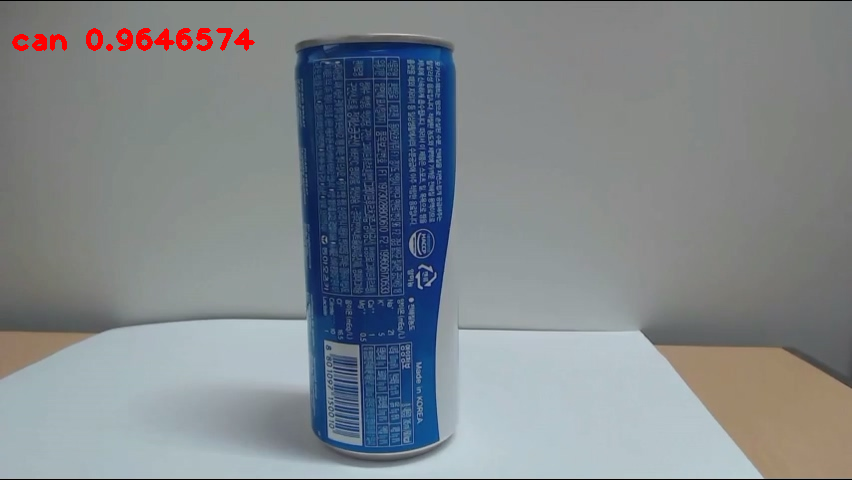

In [ ]:
# Colab에서 OpenCV 이미지를 보기 위한 패키지를 불러옵니다.
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

%cd /content/DeepLearning4Projects/Chap5

# 추론을 위한 클래스를 불러옵니다.
from Inference_Cam import Inference_Class

# 클래스를 초기화하고 모델을 불러옵니다.
inferenceClass = Inference_Class()
is_train_from_scratch = False
inferenceClass.load_model(is_train_from_scratch)

def inference(input_image):
    cv_image = []
    # str이면 경로
    if isinstance(input_image, str):
        cv_image = cv2.imread(input_image, cv2.IMREAD_COLOR)
    # 아니면 이미지를 바로 복사
    else:
        cv_image = np.copy(input_image)

    # 추론
    result_frame, label_text, class_prob = inferenceClass.inference_image(cv_image)
    print("입력 이미지는 {} % 확률로 {}으로 분류됩니다.".format((float)(class_prob) * 100, label_text))

    # 이미지 출력
    cv2_imshow(result_frame)
    return result_frame

%cd /content
input_image_path = "/content/DeepLearning4Projects/Chap5/test_image_1.jpg"
#input_image_path = "/content/DeepLearning4Projects/Chap5/test_image_2.jpg"

result = inference(input_image_path)

# Chap6: SSD 사물인지 CCTV

In [ ]:
%cd /content/drive/MyDrive/ssd/

/content/drive/MyDrive/ssd


In [ ]:
!git clone https://github.com/jetsonai/pytorch-ssd

Cloning into 'pytorch-ssd'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 162 (delta 28), reused 8 (delta 2), pack-reused 103 (from 1)
Receiving objects: 100% (162/162), 37.28 MiB | 18.03 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [ ]:
%cd pytorch-ssd

/content/drive/MyDrive/ssd/pytorch-ssd


In [ ]:
!wget https://nvidia.box.com/shared/static/djf5w54rjvpqocsiztzaandq1m3avr7c.pth -O models/mobilenet-vi-ssd-mp-0_675.pth

--2024-09-13 08:40:30--  https://nvidia.box.com/shared/static/djf5w54rjvpqocsiztzaandq1m3avr7c.pth
Resolving nvidia.box.com (nvidia.box.com)... 74.112.186.157
Connecting to nvidia.box.com (nvidia.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/djf5w54rjvpqocsiztzaandq1m3avr7c.pth [following]
--2024-09-13 08:40:30--  https://nvidia.box.com/public/static/djf5w54rjvpqocsiztzaandq1m3avr7c.pth
Reusing existing connection to nvidia.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nvidia.app.box.com/public/static/djf5w54rjvpqocsiztzaandq1m3avr7c.pth [following]
--2024-09-13 08:40:30--  https://nvidia.app.box.com/public/static/djf5w54rjvpqocsiztzaandq1m3avr7c.pth
Resolving nvidia.app.box.com (nvidia.app.box.com)... 74.112.186.157
Connecting to nvidia.app.box.com (nvidia.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loca

In [ ]:
!pip3 install -v -r requirements.txt

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Obtaining dependency information for boto3 from https://files.pythonhosted.org/packages/76/75/6eb2ffb29ec98210cf636a14b22db37b6c4d0bb431d6a6685afeed1ea42a/boto3-1.35.18-py3-none-any.whl.metadata
  Obtaining dependency information for botocore<1.36.0,>=1.35.18 from https://files.pythonhosted.org/packages/5d/48/1d81b4a661c76a60800d0cf0f87020c6acedc60fd0cf4690edeefd197ee2/botocore-1.35.18-py3-none-any.whl.metadata
  Obtaining dependency information for jmespath<2.0.0,>=0.7.1 from https://files.pythonhosted.org/packages/31/b4/b9b800c45527aadd64d5b442f9b932b00648617eb5d63d2c7a6587b7cafc/jmespath-1.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for s3transfer<0.11.0,>=0.10.0 from https://files.pythonhosted.org/packages/3c/4a/b221409913760d26cf4498b7b1741d510c82d3ad38381984a3ddc135ec66/s3transfer-0.10.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 3.2 MB/

In [ ]:
!python3 open_images_downloader.py --class-names "Person, Car, Bus" --data=data/cctv --max-images=4500 --num-workers=2

2024-09-13 08:51:52 - Download https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv.
2024-09-13 08:51:52 - Requested 3 classes, found 3 classes
2024-09-13 08:51:52 - Download https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv.
2024-09-13 08:52:08 - Read annotation file data/cctv/train-annotations-bbox.csv
2024-09-13 08:52:39 - Available train images:  302983
2024-09-13 08:52:39 - Available train boxes:   1174637

2024-09-13 08:52:39 - Download https://storage.googleapis.com/openimages/2018_04/validation/validation-annotations-bbox.csv.
2024-09-13 08:52:40 - Read annotation file data/cctv/validation-annotations-bbox.csv
2024-09-13 08:52:40 - Available validation images:  10333
2024-09-13 08:52:40 - Available validation boxes:   21748

2024-09-13 08:52:40 - Download https://storage.googleapis.com/openimages/2018_04/test/test-annotations-bbox.csv.
2024-09-13 08:52:41 - Read annotation file data/cctv/test-annotations-bbox.csv
2024

In [ ]:
!pwd

/content/drive/MyDrive/ssd/pytorch-ssd


In [ ]:
!python3 train_ssd.py --data=data/cctv --model-dir=models/cctv --batch-size=16 --epochs=10

2024-09-13 08:52:52 - Using CUDA...
2024-09-13 08:52:52 - Namespace(dataset_type='open_images', datasets=['data/cctv'], balance_data=False, net='mb1-ssd', freeze_base_net=False, freeze_net=False, mb2_width_mult=1.0, base_net=None, pretrained_ssd='models/mobilenet-v1-ssd-mp-0_675.pth', resume=None, lr=0.01, momentum=0.9, weight_decay=0.0005, gamma=0.1, base_net_lr=0.001, extra_layers_lr=None, scheduler='cosine', milestones='80,100', t_max=100, batch_size=16, num_epochs=10, num_workers=2, validation_epochs=1, debug_steps=10, use_cuda=True, checkpoint_folder='models/cctv')
2024-09-13 08:52:52 - Prepare training datasets.
2024-09-13 08:52:52 - loading annotations from: data/cctv/sub-train-annotations-bbox.csv
Traceback (most recent call last):
  File "/content/drive/MyDrive/ssd/pytorch-ssd/train_ssd.py", line 221, in <module>
    dataset = OpenImagesDataset(dataset_path,
  File "/content/drive/MyDrive/ssd/pytorch-ssd/vision/datasets/open_images.py", line 19, in __init__
    self.data, self

In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
!ls -al models/cctv/mb1-ssd-Epoch-34*

ls: cannot access 'models/cctv/mb1-ssd-Epoch-34*': No such file or directory
